In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report


%config InlineBackend.figure_formats = ['svg']

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

cmap= mpl.colors.ListedColormap(['red', 'black', 'blue'])

## Task 1 Decision Boundary from a Maximal Margin Classifier (4 points)

Let's create some synthetic data with two classes:

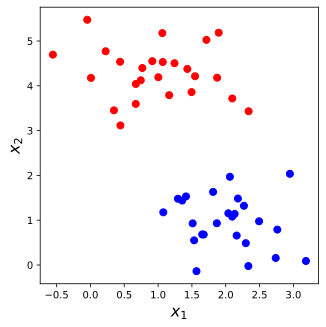

In [2]:
X, y = datasets.make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

y[np.where(y==0)] = -1

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)

plt.show()

In this task we will use the `SVC` model of `sklearn.svm` with a `kernel=linear` and large parameter `C`. `sklearn`'s module `svm` has implementations of several Support Vector Machine algorithms. Some are meant to solve Regression, some - Classification problems. `LinearSVC` stands for Linear Support Vector Classification which is exactly what we need in order to solve the maximal margin classification problem. However, `svm.SVC` offers more flexibility in order to extract the learned parameters etc.

In [3]:
model = svm.SVC(kernel='linear', C=1000, tol=0.0001) # initialize the model
model.fit(X, y) # fit the model = learn the decision boundaries

SVC(C=1000, kernel='linear', tol=0.0001)

When the optimisation has completed, you can access the parameters of the separating hyperplane. The vector $\mathbf{w}$ and the bias/offset term $b$ are then as follows:

In [4]:
print("w = ", model.coef_)
print("b = ", model.intercept_)

w =  [[ 0.2354745  -1.41254898]]
b =  [3.2961071]


The indices of the support vectors are:

In [5]:
print(model.support_)

[18 25  7]


So you can slice $\mathbf{X}$ for the corresponding coordinates of the support vectors:

In [6]:
X[model.support_]

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Or get them directly:

In [7]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

**Task 1A** Calculate $y^{(m)}\left(b+w^Tx^{(m)}\right)$ for every support vector.
## 📢 **HAND-IN** 📢: Report the calculated values from Task 1A in Moodle

In [8]:
# SOLUTION 1 (concise)

w = model.coef_[0]
w_norm = np.linalg.norm(w)
b = model.intercept_[0]
y[model.support_] * (np.dot(w, X[model.support_].T) + b)

array([0.99996393, 1.00001735, 0.99998206])

In [9]:
# SOLUTION 2 (more verbose)

w = model.coef_[0]
b = model.intercept_[0]
support_vectors = model.support_vectors_
support_vector_labels = y[model.support_]

results = []

for i, support_vector in enumerate(support_vectors):
    y_m = support_vector_labels[i]
    w_dot_x = np.dot(w, support_vector)
    value = y_m * (b + w_dot_x)
    results.append((support_vector, value))
    print(f"\n\nsupport_vector = {support_vector}")
    print(f"y_m = {y_m}")
    print(f"w_dot_x = {w_dot_x}")
    print(f"value = {value}")

results



support_vector = [0.44359863 3.11530945]
y_m = -1
w_dot_x = -4.29607102294105
value = 0.999963925990754


support_vector = [2.33812285 3.43116792]
y_m = -1
w_dot_x = -4.296124448649409
value = 1.0000173516991127


support_vector = [2.06156753 1.96918596]
y_m = 1
w_dot_x = -2.2961250351671265
value = 0.9999820617831698


[(array([0.44359863, 3.11530945]), 0.999963925990754),
 (array([2.33812285, 3.43116792]), 1.0000173516991127),
 (array([2.06156753, 1.96918596]), 0.9999820617831698)]

To find $=1$ was expected. When deriving the optimisation problem Eq. 6.8 was scaled such that such that $y^{(m)}f(\mathbf{x}^{(m)})=1$ for the point(s) closest to the decision boundary, i.e. the support vectors.

**Task 1B** Calculate the distance from the decision boundary to the support vectors, i.e. the width of the margin.

The (signed) perpendicular distances of the hyperplane to any point $\mathbf{x}$:
$$r=\frac{(b+w^T\mathbf{x})}{||\mathbf{w}||}$$
Insert the positions of the support vectors and multiply by $y^{(m)}$ to get the unsigned distance

In [10]:
# SOLUTION 1 (concise)

dists = y[model.support_] * (np.dot(w, X[model.support_].T) + b)/w_norm
dists

array([0.69827859, 0.6983159 , 0.69829126])

In [11]:
# SOLUTION 2 (verbose)

w_norm = np.linalg.norm(w)

distances = []

for support_vector in support_vectors:
    w_dot_x = np.dot(w, support_vector)
    distance = np.abs(b + w_dot_x) / w_norm
    distances.append(distance)

distances

[0.6982785929127894, 0.698315900287074, 0.6982912572052506]

This is the same for all support vectors!

## 📢 **HAND-IN** 📢: Report the width of the margin calculated in Task 1B in Moodle


## Task 2 Large Margin Classifier on the Wine Dataset (2 points)

Now, we will apply support vector machine classification on a more realistic dataset.

This dataset `sklearn.datasets.load_wine()` contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?

In [12]:
wine = datasets.load_wine(as_frame=True)
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [14]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [15]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

SVC will automatically use the One-vs-All strategy, so there's nothing special we need to do to handle multiple classes.

In [16]:
model = svm.SVC(kernel='linear', C=1000, tol=0.0001, random_state=42) # initialize the model

Calulate the accuracy (cross validation score):

In [17]:
from sklearn.model_selection import cross_val_score

model = svm.SVC(kernel='linear', C=1000, tol=0.0001, random_state=42) # initialize the model
model.fit(X_train, y_train) # fit the model = learn the decision boundaries

# Accuracy:
print(cross_val_score(model, X_train, y_train).mean())


0.9176638176638177


If you perform the cross-validation manually:

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

X_train.head()
y_train.head()
model = svm.SVC(kernel='linear', C=1000, tol=0.0001, random_state=42) # initialize the model

# Train the model on the training data
model.fit(X_train, y_train)

# Teil 1

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation and calculate accuracy
accuracies = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean accuracy over all folds
mean_accuracy = accuracies.mean()
print(f"Mean Accuracy: {mean_accuracy}%")

Mean Accuracy: 0.9176638176638177%


**Task 2A**: Which accuracy (cross validation score) can you reach when you standarize the features before training?  
See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

model = make_pipeline(preprocessing.StandardScaler(),
                     svm.SVC(kernel='linear', C=10000000, tol=0.0001, random_state=42))
model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train).mean()

0.9772079772079773

In [20]:
# cross_val_score(...).mean()

from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM model
model = svm.SVC(kernel='linear', C=1000, tol=0.0001, random_state=42)

# Perform cross-validation and calculate the mean accuracy after standardizing the features
accuracies_scaled = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
mean_accuracy_scaled = accuracies_scaled.mean()

mean_accuracy_scaled

0.9772079772079773

## 📢 **HAND-IN** 📢:
2A: Report the accuracy that you reached with feature standaridsation in Moodle


In order to plot the decision boundary and margins of SVM's, we will use the DecisionBoundaryDisplay.from_estimator from sklearn and wrap it into a function for reuse:

In [21]:
def plot_svc_decision_function(model, X, y, ax):
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap)

    DecisionBoundaryDisplay.from_estimator(
        estimator=model, X=X,ax=ax,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["grey", "black", "grey"],
        linestyles=["--", "-", "--"],
    )

    # indicate the support vectors
    ax.scatter(X[model.support_][:, 0], X[model.support_][:, 1],
               facecolors='none', edgecolors='black', s=100)

    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)

# TASK 3. SVM (2 Points): Soft Margin Classifier


Let's work on the same artificial data with two classes.

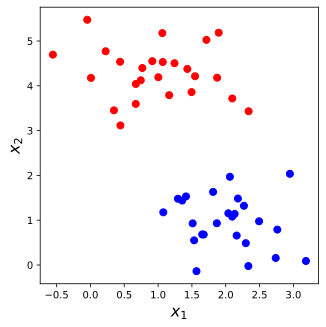

In [22]:
X, y = datasets.make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)
plt.show()

In [23]:
model = svm.SVC(kernel='linear', C=0.1) # initialize the model
model.fit(X, y) # fit the model = learn the decision boundaries

SVC(C=0.1, kernel='linear')

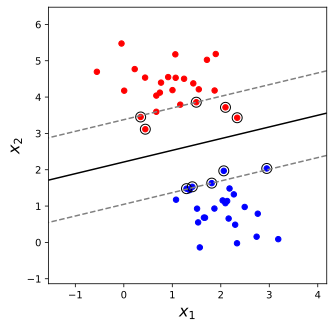

In [24]:
_, ax = plt.subplots(figsize=(5, 5))

plot_svc_decision_function(model, X, y, ax)

plt.show()

In the plot you see a solid and 2 dashed lines.

The solid line shows the decision boundary, meaning points on one side will be assigned to the blue class and on the other side to the red class. In this case all
data points lie on the correct side of the decision boundary, meaning our classifier has successfully learned to separate the classes.

The dashed lines visualize the margin of the SVM classifier. You can see that a
few points lie inside the margin. This is because, in practice, we use a soft-margin implementation for SVM. This means that we allow data points to be inside the margin, or even on the wrong side of the boundary, but during training we "punish" these points.

In the next excercise we will investigate the effect of the `C` parameter of. This
parameter controls how much we "punish" points inside (or on the wrong side) of the margin.

### Regularization
For each value `C` given in the code fragment below create an instance of SVC and set its parameter C accordingly. Train the model on the data `X` from the cells above. Plot the decision boundary using `plot_svc_decision_function(model, X, y, ax)`. Observe the effect from the plots and discuss with your colleagues whether it is in line with your expectation.



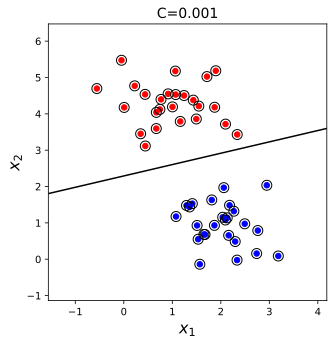

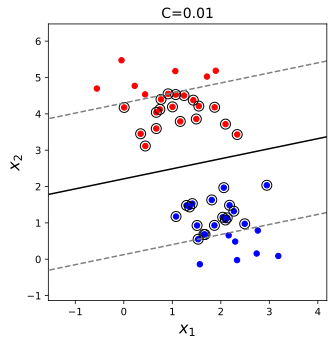

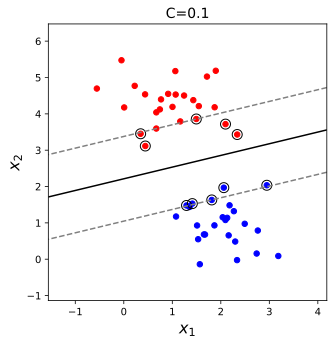

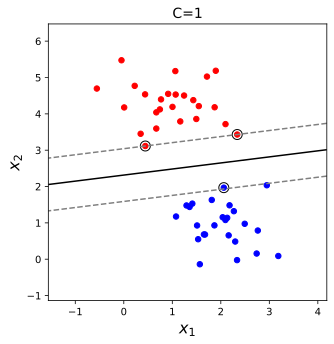

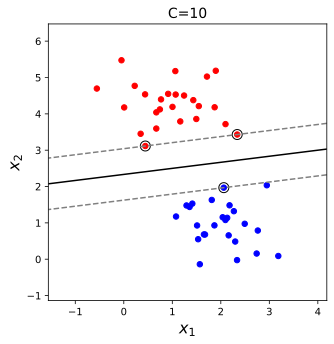

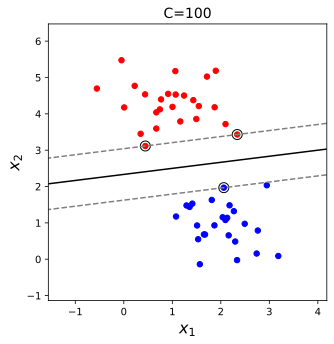

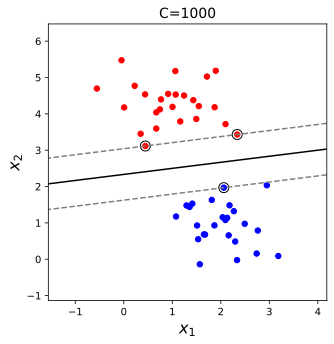

In [25]:
for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    # create an instance of SVC and set its parameter C
    # call its .fit method to train it on X and y

    model = svm.SVC(kernel='linear', C=c)
    model.fit(X, y)

    _, ax = plt.subplots(figsize=(5, 5))
    plot_svc_decision_function(model, X, y, ax)
    ax.set_title(f"C={c}")
    plt.show()

### We add a new datapoint

We will now add a new red data point, that lies very close to the cluster of blue points.

In real world datasets, we run into this situation all the time. One reason can be that some data points really do look very similar but belong to different classes (e.g. imagine distinguishing a crocodile from an alligator). Another reason could be that the data point would really belong to the other (blue) class but has been annotated badly.

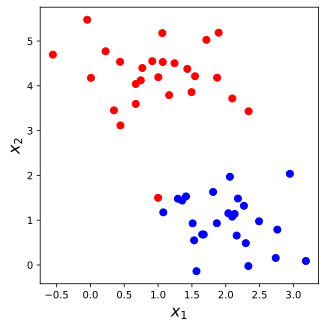

In [26]:
X2 = np.append(X, [[1., 1.5]], axis=0)
y2 = np.append(y, [0], axis=0)

_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap=cmap)
ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)
plt.show()

Rerun the examle from above, i.e. train a linear `SVC` with different values of `C` and see what changes.

Pay particular attention to how the new data point changes the outcome.

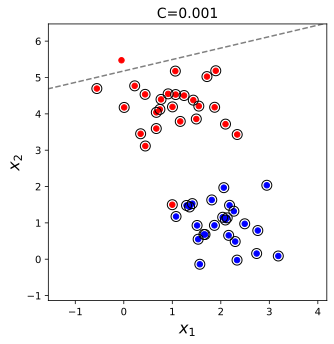

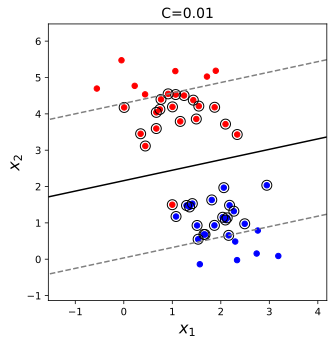

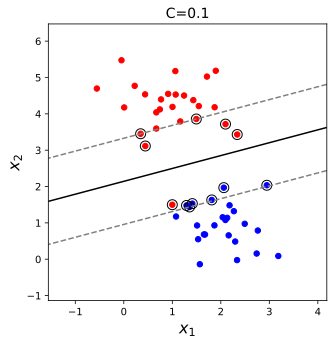

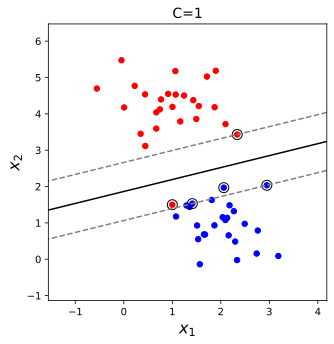

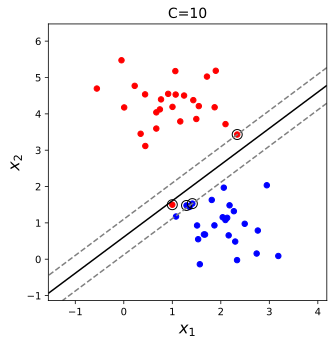

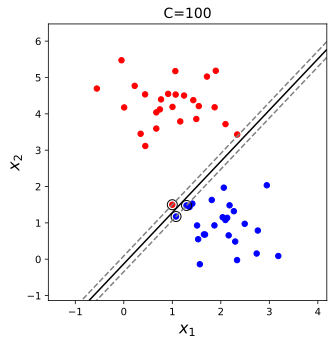

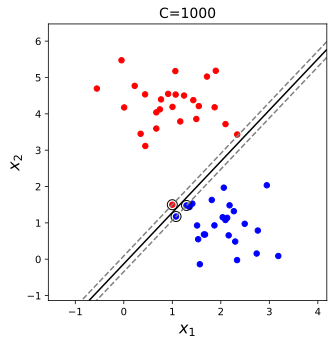

In [27]:
for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    # create an instance of LinearSVC and set its parameter C
    # call its .fit method to train it on X2 and y2

    model = svm.SVC(kernel='linear', C=c)
    model.fit(X2, y2)
    
    _, ax = plt.subplots(figsize=(5, 5))
    plot_svc_decision_function(model, X2, y2, ax)
    ax.set_title(f"C={c}")
    plt.show()


## 📢 **HAND-IN Task 3A** 📢: Submit the following task in Moodle:

Based on the experiments in **task 3** above, which value for `C` would you choose for the new data, and **why**?  
And Upload the image of the corresponding plot.



# Task 4. SVM Kernel Trick (3 points)
In this task we will investigate the case of non-linearly separable data. In order to handle such a case, the **Kernel Trick** can be used. We transform our data and map it into a **higher dimensional feature space** (e.g., if the data had two features (2D-space), it becomes 3D-space). The goal is that after the transformation to the higher dimensional space, the classes will be linearly separable. The decision boundary can then be fitted to separate the classes and make predictions. The decision boundary will be a hyperplane in this higher dimensional space.


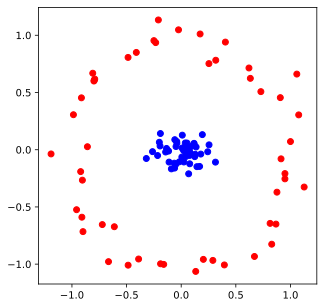

In [28]:
X_non_linear, y_non_linear = datasets.make_circles(100, factor=.1, noise=.1)

_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_non_linear[:, 0], X_non_linear[:, 1], c=y_non_linear, cmap=cmap)
plt.show()

### Default model

Below you can see what happens if we naively train a linear `SVC` model on this non-linear dataset.

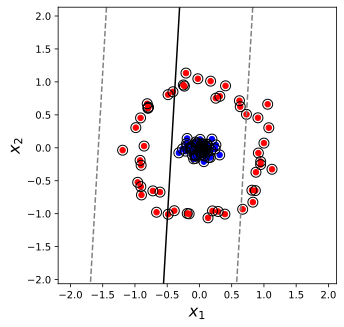

In [29]:
clf = svm.SVC(kernel='linear').fit(X_non_linear, y_non_linear)

_, ax = plt.subplots(figsize=(5, 5))
plot_svc_decision_function(clf, X_non_linear, y_non_linear, ax)
plt.show()

In [30]:
print(classification_report(y_true=y_non_linear, y_pred=clf.predict(X_non_linear), digits=3))

              precision    recall  f1-score   support

           0      1.000     0.360     0.529        50
           1      0.610     1.000     0.758        50

    accuracy                          0.680       100
   macro avg      0.805     0.680     0.643       100
weighted avg      0.805     0.680     0.643       100



### Manually Adding a Helper Dimension

It is clear that no linear discrimination will ever be able to separate this data. We can think about how we might project the data into a higher dimension such that a linear separator would be sufficient. In the code below we compute a new value `r` based on the data points. Adding `r` as a new dimension to our data, we will see that the data becomes linearly separable.

We compute $r = e^{-||x||^2}$. We chose this because the data points lie on circles and $||x||^{2}$ corresponds to the radius of the circle that a data point lies on. The exponential is often used for numerical stability. However in this case, the picture would look the same when plotting $-||x||^{2}$ directly.

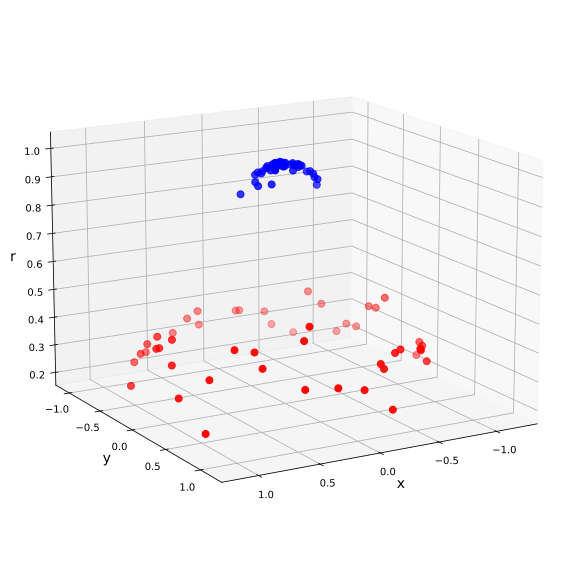

In [31]:
r = np.exp(-(X_non_linear ** 2).sum(1))

fig1=plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(projection='3d')
ax.scatter3D(X_non_linear[:, 0], X_non_linear[:, 1], r,
             c=y_non_linear, s=50, cmap=cmap)
ax.view_init(elev=15, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')

plt.show()

### 4. Linear Classification in the extended feature space

Task: Append the additional feature `r` to the original data `X_non_linear` and train a linear `SVC` in the extended feature space.

In [32]:
# Append the new feature r to the original data
X_3d = np.insert(X_non_linear, 2, r, axis=1)

# Train a linear SVC model in the extended feature space
clf_3d = svm.SVC(kernel='linear').fit(X_3d, y_non_linear)

Have the accuracy metrics improved?

In [33]:
print(classification_report(y_true=y_non_linear, y_pred=clf_3d.predict(X_3d), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      1.000     1.000     1.000        50

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100



We can now visualise the learned decision boundary in the extended feature space together with the transformed data:

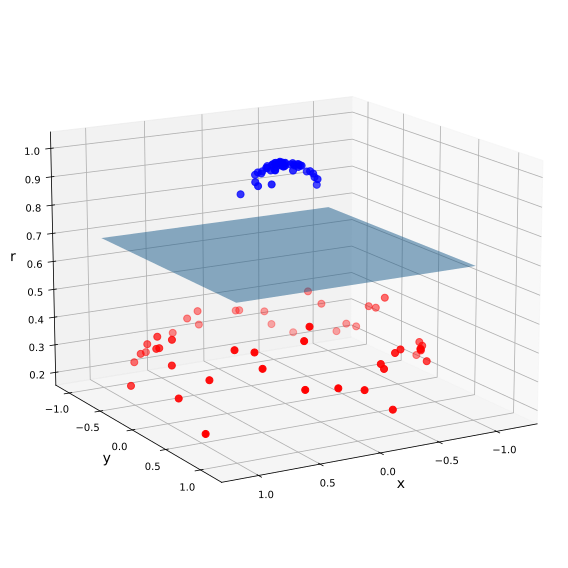

In [34]:
# get the parameters from the optimised model that specify the decision boundary
w = clf_3d.coef_[0]

b=clf_3d.intercept_[0]

fig1=plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(projection='3d')
ax.scatter3D(X_non_linear[:, 0], X_non_linear[:, 1], r,
             c=y_non_linear, s=50, cmap=cmap)
ax.view_init(elev=15, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')

# Surface plot of the decision boundary (a plane) from the
# optimised parameters
xx, yy = np.meshgrid(np.linspace(-1,1,2),np.linspace(-1,1,2))
# 0=b+w_0*x+w_1*y+w_2*z  ->  rearrange for z
z = -(b + w[0]*xx * w[1]*yy) / w[2]
ax.plot_surface(xx, yy, z, alpha=0.5)

plt.show()


## 📢 **HAND-IN Task 4** 📢: Submit the following task in Moodle:

Report for **task 4** the accuracy from the classification report achieved with the linear SVM in the extended feature space and upload the image of the 3D-plot including the decision boundary.